## Assignment 2.4: Text classification via CNN (20 points)

In this assignment you should perform sentiment analysis of the IMDB reviews based on CNN architecture. Read carefully [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882.pdf) by Yoon Kim.

In [1]:
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import datasets
from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator
from torchtext.data import Iterator

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Preparing Data

In [0]:
TEXT = Field(sequential=True, lower=True, batch_first=True)
LABEL = LabelField(batch_first=True)

In [3]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split()

aclImdb_v1.tar.gz:   0%|          | 115k/84.1M [00:00<01:13, 1.15MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 47.7MB/s]


In [0]:
# %%time
TEXT.build_vocab(trn)

In [0]:
LABEL.build_vocab(trn)

### Creating the Iterator (2 points)

Define an iterator here

In [0]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(64, 64, 64),
        sort=True,
        sort_within_batch=False,
        device='cuda',
        # device='cpu',
        repeat=False
)

### Define CNN-based text classification model (8 points)

In [0]:
class CNN(nn.Module):
    def __init__(self, V, D, kernel_sizes, out_channels, dropout=0.5):
        super(CNN, self).__init__()
        
        self.emb = nn.Embedding(V, D)
        # self.convs = nn.ModuleList([nn.Conv1d(D, 1, (K, D)) 
        #     for K in kernel_sizes])
        self.convs = nn.ModuleList([nn.Conv1d(D, out_channels, K) 
            for K in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(out_channels * len(kernel_sizes), 1)
        
    def forward(self, x):
        x = self.emb(x)
        x = x.permute(0, 2, 1)
        x = [F.relu(conv(x))for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.linear(x).reshape(-1)
        return logit

In [0]:
kernel_sizes = [3,4,5]
vocab_size = len(TEXT.vocab)
dropout = 0.5
dim = 300
out_channels = 100

model = CNN(vocab_size, dim, kernel_sizes, out_channels, dropout)

In [23]:
model.cuda()

CNN(
  (emb): Embedding(201698, 300)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)

### The training loop (3 points)

Define the optimization function and the loss functions.

In [0]:
learning_rate = 1e-3
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.BCEWithLogitsLoss()

Think carefully about the stopping criteria. 

In [0]:
epochs = 30

In [0]:
def train_loop():
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        running_corrects = 0
        model.train() 
        for batch in train_iter:           
            x = batch.text
            y = batch.label

            opt.zero_grad()
            preds = model(x)
            loss = loss_func(preds, y.float())
            loss.backward()
            opt.step()
            running_loss += loss.item()

        torch.save(model.state_dict(), f'cnn_base_{epoch}.pt')
        epoch_loss = running_loss / len(trn)
        train_loss_history.append(epoch_loss)

        val_loss = 0.0
        model.eval()
        for batch in val_iter:
            x = batch.text
            y = batch.label

            preds = model(x) 
            loss = loss_func(preds, y.float())
            val_loss += loss.item()
          
        val_loss /= len(vld)
        valid_loss_history.append(val_loss)
        print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(
          epoch, epoch_loss, val_loss))

In [27]:
%%time

train_loss_history = []
valid_loss_history = []

train_loop()

Epoch: 1, Training Loss: 0.009720080760547093, Validation Loss: 0.007165106495221456
Epoch: 2, Training Loss: 0.007301585112299238, Validation Loss: 0.0064335808674494425
Epoch: 3, Training Loss: 0.006134698700053351, Validation Loss: 0.005580290647347768
Epoch: 4, Training Loss: 0.00485636630824634, Validation Loss: 0.005603609291712443
Epoch: 5, Training Loss: 0.0034554493248462677, Validation Loss: 0.005549495093027751
Epoch: 6, Training Loss: 0.0023010601148009302, Validation Loss: 0.006439545915524165
Epoch: 7, Training Loss: 0.0014249966422361987, Validation Loss: 0.0066114761610825854
Epoch: 8, Training Loss: 0.0008963198467024735, Validation Loss: 0.007220714261134465
Epoch: 9, Training Loss: 0.0005791894875067685, Validation Loss: 0.007688733375072479
Epoch: 10, Training Loss: 0.00038383525735698643, Validation Loss: 0.011507985673348108
Epoch: 11, Training Loss: 0.00024029919810792698, Validation Loss: 0.010932444900274276
Epoch: 12, Training Loss: 0.0002012422246209878, Vali

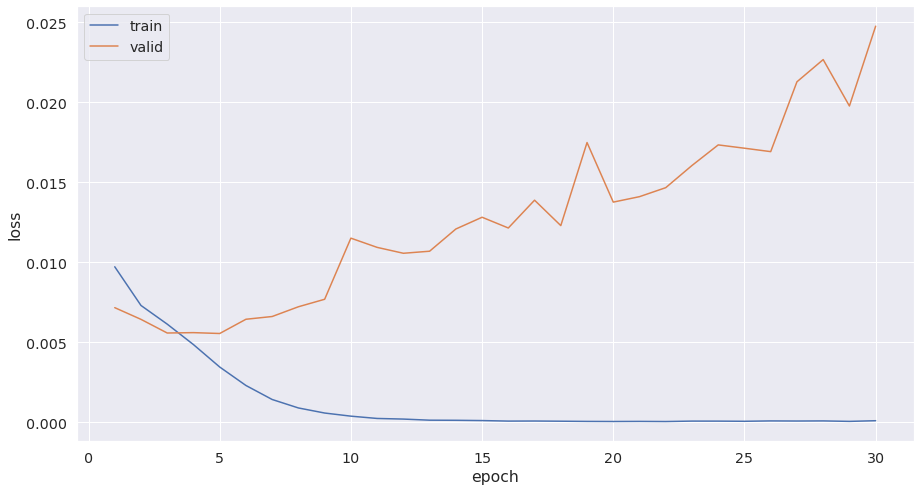

In [28]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(epochs) + 1, train_loss_history, label='train')
plt.plot(np.arange(epochs) + 1, valid_loss_history, label='valid')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

It seems that model on epoch $5$ had the best score on validation, then model started to overfit.

In [29]:
model.load_state_dict(torch.load('cnn_base_5.pt'))

<All keys matched successfully>

### Calculate performance of the trained model (2 points)

In [0]:
y_pred = []
y_true = []
model.eval()

for batch in test_iter:
    x = batch.text
    y = batch.label

    y_pred += list((torch.sigmoid(model(x)) >= 0.5).detach().cpu().numpy())
    y_true += list((y.detach().cpu().numpy()))

In [31]:
print(accuracy_score(y_true, y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

0.84932
0.9170885471391728
0.76808
0.8359963428969481


Write down the calculated performance

### Accuracy: 0.84932
### Precision: 0.91709
### Recall: 0.76808
### F1: 0.835996

### Experiments (5 points)

Experiment with the model and achieve better results. Implement and describe your experiments in details, mention what was helpful.

### 1. WORK IN PROGRESS(maybe)
### 2. ?
### 3. ?